## Imports

In [67]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import DirectoryIterator
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow import keras
from tensorflow.keras.models import Model
import os
from pathlib import Path
import io
from tqdm import tqdm
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy import sqrt
from numpy import argmax
import seaborn as sns
import math
import random
import sklearn
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

## Define Custom Generator

In [68]:
class CustomDataGen(tf.keras.utils.Sequence):
    def __init__(self,
                 no_obs_dir,
                 obs_dir,
                 batch_size=32,
                 input_size=(200, 200),
                 shuffle=True):
        
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        no_obs_imnames = os.listdir(no_obs_dir)
        obs_imnames = os.listdir(obs_dir)
        self.no_obs = [[os.path.join(no_obs_dir, name), 0] for name in no_obs_imnames]
        self.obs = [[os.path.join(obs_dir, name), 1] for name in obs_imnames]
        self.items = self.no_obs + self.obs
        self.filenames = [item[0] for item in self.items]
        self.labels = [item[1] for item in self.items]
        self.n = len(self.items)
        self.steps = math.ceil(self.n/self.batch_size)
        if self.shuffle:
            random.shuffle(self.items)
        self.image_written = False
        
    def __getitem__(self, index):
        start = index * self.batch_size
        end = min((index+1) * self.batch_size, self.n)
        items = self.items[start:end]
        im1_s, im2_s, im3_s, labels = [], [], [], []

        for item in items:
            # Read image
            im = cv2.imread(item[0])
            im = cv2.resize(im, dsize=(600, 200), interpolation=cv2.INTER_NEAREST)
            imarr = np.array(im, dtype='float32')
            imarr /= 255.0
            w = imarr.shape[1]

            # Split to 3 components
            im1 = imarr[:, :w//3]
            im2 = imarr[:, w//3:(w*2)//3] 
            im3 = imarr[:, (w*2)//3:] 

            # 3rd component to grayscale
            im3 = cv2.cvtColor(im3, cv2.COLOR_RGB2GRAY)

            # Add each component to its batch
            im1_s.append(im1)
            im2_s.append(im2)
            im3_s.append(im3)
            labels.append(item[1])

        im1_s = np.array(im1_s)
        im2_s = np.array(im2_s)
        im3_s = np.array(im3_s)
        labels = np.array(labels)

        return [im1_s, im2_s, im3_s], labels 
    
    def __len__(self):
        return self.steps

## Classes to handle dataset images

In [69]:
class DatasetHandler:
    def __init__(self,
                 model_path,
                 dataset,
                 img_width=600,
                 img_height=200,
                 batch_size=32):
        
        self.model_path = model_path
        self.dataset = dataset
        self.no_obstacle_dataset = os.path.join(dataset, 'no_obstacle')
        self.obstacle_dataset = os.path.join(dataset, 'obstacle')
        self.img_width = img_width
        self.img_height = img_height
        self.no_obstacle_images = []
        self.obstacle_images = []
        self.sdv_images = []
        self._update_image_lists = False
        self.batch_size = batch_size
            
        # Will be determined while reading all images from dataset
        self.num_no_obstacles = 0
        self.num_obstacles = 0
        self.num_sdvs = 0
        self.num_images = 0
            
        (self.no_obstacle_image_names,
        self.num_no_obstacles) = self._get_all_dataset_image_names(self.dataset, 'no_obstacle')
        (self.obstacle_image_names,
        self.num_obstacles) = self._get_all_dataset_image_names(self.dataset, 'obstacle')
        self.datagen, self.steps = self.get_datagen(self.batch_size)
                            
    def _get_all_dataset_image_names(self, dataset, class_name):
        class_dataset = os.path.join(dataset, class_name)
        image_names = os.listdir(class_dataset)
        image_paths = [os.path.join(class_dataset, image_name) for image_name in image_names]
        
        return image_paths, len(image_paths)
            
    def _get_image(self, imname):
        imrgb = cv2.imread(imname)
        im = cv2.cvtColor(imrgb, cv2.COLOR_BGR2GRAY) 
        
        return im
    
    def get_datagen(self, batch_size):
        datagen = ImageDataGenerator(rescale=1./255.)
        it = DirectoryIterator(self.dataset, image_data_generator=datagen, batch_size=batch_size)
        steps= it.__len__()
        
        return datagen, steps
 
    def get_metrics(self, model, color_mode='rgb'):
        eval_generator = self.three_im_generator_common_size(
            self.datagen,
            self.dataset,
            target_size=(self.img_height, self.img_width),
            batch_size=self.batch_size,
            #class_mode='binary'
            class_mode='categorical'
        )
        
        return model.evaluate(eval_generator, steps=self.steps, verbose=1)
        
    def get_predictions(self, model, color_mode='rgb'):
        predict_generator = CustomDataGen(self.no_obstacle_dataset,
                                          self.obstacle_dataset,
                                          shuffle=False)
        self.filenames = predict_generator.filenames
        self.labels = predict_generator.labels
        self.items = predict_generator.items
        return model.predict(predict_generator, steps=self.steps, verbose=1)
        
    def print_model_metrics(self, model, color_mode):
        metrics = self.get_metrics(model, color_mode)

        for name, value in zip(model.metrics_names, metrics):
            print(name, ': ', value)
            
    # Compute and plot multi-class confusion-matrix
    def plot_cm(self, model_path, labels, predictions, threshold):
        cm = confusion_matrix(labels, predictions > threshold) 
        print(f'cm: {cm}')
        sns.heatmap(cm, annot=True, fmt='d')
        plt.title(f'Threshold = {threshold}')
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label') 
        
    # Compute and plot multi-class confusion-matrix with normalization
    def plot_cm_normalized(self, model_path, labels, predictions, threshold):
        cm = confusion_matrix(labels, predictions > threshold)
        print(f'cm: {cm}')
        # Normalise
        cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fig, ax = plt.subplots(figsize=(5, 5))
        sns.heatmap(cmn, annot=True, fmt='.3f')
        plt.title(f'Threshold = {threshold}')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show(block=False)  
                
    def save_false_positives(self, predictions, threshold, save_path):
        false_positives = [fname for i, fname in enumerate(self.filenames[:self.num_no_obstacles])\
                           if predictions[i] > threshold]
        preds = [p for i, p in enumerate(predictions[:self.num_no_obstacles]) if p > threshold]

        fp_path = os.path.join(save_path, 'false_positives')
        Path(fp_path).mkdir(parents=True, exist_ok=True)
        for i, fname in enumerate(false_positives):
            imname = fname.split('/')[-1]
            in_path = os.path.join(self.no_obstacle_dataset, imname)
            im = cv2.imread(in_path)
            imname = imname.split('_')
            imname.insert(2, f'{preds[i][0]:.2f}')
            imname = '_'.join(imname)
            out_path = os.path.join(fp_path, imname)
            cv2.imwrite(out_path, im)
            
        # Return the prediction as a list for histogram plot
        fp_preds = [p[0] for p in preds]
        return fp_preds
            
    def save_true_positives(self, predictions, threshold, save_path):
        true_positives = [fname for i, fname in enumerate(self.filenames[self.num_no_obstacles:])\
                           if predictions[self.num_no_obstacles+i] > threshold]
        preds = [p for i, p in enumerate(predictions[self.num_no_obstacles:]) if p > threshold]

        tp_path = os.path.join(save_path, 'true_positives')
        Path(tp_path).mkdir(parents=True, exist_ok=True)
        for i, fname in enumerate(true_positives):
            imname = fname.split('/')[-1]
            in_path = os.path.join(self.obstacle_dataset, imname)
            im = cv2.imread(in_path)
            imname = imname.split('_')
            imname.insert(2, f'{preds[i][0]:.2f}')
            imname = '_'.join(imname)
            out_path = os.path.join(tp_path, imname)
            cv2.imwrite(out_path, im)

    def save_false_negatives(self, predictions, threshold, save_path):
        false_negatives = [fname for i, fname in enumerate(self.filenames[self.num_no_obstacles:])\
                           if predictions[self.num_no_obstacles+i] <= threshold]
        preds = [p for i, p in enumerate(predictions[self.num_no_obstacles:]) if p <= threshold]
        
        fn_path = os.path.join(save_path, 'false_negatives')
        Path(fn_path).mkdir(parents=True, exist_ok=True)
        for i, fname in enumerate(false_negatives):
            imname = fname.split('/')[-1]
            in_path = os.path.join(self.obstacle_dataset, imname)
            im = cv2.imread(in_path)
            imname = imname.split('_')
            imname.insert(2, f'{preds[i][0]:.2f}')
            imname = '_'.join(imname)
            out_path = os.path.join(fn_path, imname)
            cv2.imwrite(out_path, im)
            
        # Return the prediction as a list for histogram plot
        fn_preds = [p[0] for p in preds]
        return fn_preds
            
    def save_true_negatives(self, predictions, threshold, save_path):
        true_negatives = [fname for i, fname in enumerate(self.filenames[:self.num_no_obstacles])\
                           if predictions[i] <= threshold]
        preds = [p for i, p in enumerate(predictions[:self.num_no_obstacles]) if p <= threshold]
        
        tn_path = os.path.join(save_path, 'true_negatives')
        Path(tn_path).mkdir(parents=True, exist_ok=True)
        for i, fname in enumerate(true_negatives):
            imname = fname.split('/')[-1]
            in_path = os.path.join(self.no_obstacle_dataset, imname)
            im = cv2.imread(in_path)
            imname = imname.split('_')
            imname.insert(2, f'{preds[i][0]:.2f}')
            imname = '_'.join(imname)
            out_path = os.path.join(tn_path, imname)
            cv2.imwrite(out_path, im)

## Main

Found 2430 images belonging to 2 classes.
76/76 [==============================] - 32s 417ms/step
cm: [[1190   14]
 [  13 1213]]


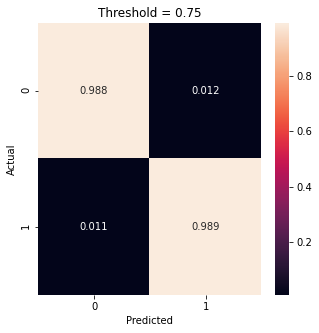

In [70]:
# -- Variables --
model_path = '/home/drevital/cs_video_processor/models/jun22_f'
dataset = '/home/drevital/obstacles_classification_datasets/jun22_f/eval'
model_name = model_path.split('/')[-1]
color_mode = 'rgb'
thresholds = [0.75]
batch_size = 32
save_base_path = '/home/drevital/obstacles_classification_datasets/model_eval_new_method'

# -- Run the Evaluation --
model = tf.keras.models.load_model(model_path)
handler = DatasetHandler(model_path, dataset, batch_size=batch_size)

# -- Define Labels
#labels = np.array([0]*handler.num_no_obstacles\
#                + [1]*handler.num_obstacles)

# -- Predict with the model
predictions = handler.get_predictions(model, color_mode=color_mode)

for threshold in thresholds:
    # -- Print confision-matrix
    handler.plot_cm_normalized(model_path, handler.labels, predictions, threshold=threshold)

    # -- Save Images
    save_name = dataset.split('/')[-2] + '_' + str(threshold)
    save_path = os.path.join(save_base_path, save_name)
    fn_preds = handler.save_false_negatives(predictions, threshold=threshold, save_path=save_path)
    fp_preds = handler.save_false_positives(predictions, threshold=threshold, save_path=save_path)
    handler.save_true_negatives(predictions, threshold=threshold, save_path=save_path)
    handler.save_true_positives(predictions, threshold=threshold, save_path=save_path)

In [71]:
predictions

array([[0.0255253 ],
       [0.20471415],
       [0.11698979],
       ...,
       [0.9985048 ],
       [0.98502874],
       [0.9990718 ]], dtype=float32)